---
title: "Overfitting and The Train-Test Split"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2023-12-08"
image: thumbnail.png
categories: ['Python', 'Statistics']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
editor: 
  markdown: 
    wrap: 72
---

In [32]:
#| code-fold: true
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor


def model_data_lm(degree, df):
    X = df[["Education"]].values
    y = df["Income"].values
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    rmse = mean_squared_error(y, model.predict(X)) ** 0.5
    r2 = r2_score(y, model.predict(X))
    X_test = np.linspace(X.min() - 1.5 * X.std(), X.max() + 1.5 * X.std(), 100).reshape(
        -1, 1
    )
    y_pred = model.predict(X_test)

    return X_test, y_pred, rmse, r2, model

## Some Notes on Modeling Data and Resampling Methods

The following is an exercise with synthetic data intended to memorialize some thoughts on models and resampling methods. I won't reference a lot of specific books here, but generally this post is influenced by @james_introduction_2013 and @hastie_elements_2016.

To begin, say we are examining the relationship between income and years of education.

In [33]:
df = pd.DataFrame()
np.random.seed(46)
n = 200
education_dgp = lambda n: np.random.lognormal(1.2, 0.6, n)
education = education_dgp(n)
df["Education"] = education

Let's say that income is a function of years of education:

In [34]:
np.random.seed(49)
df["Income"] = 33000 + 6000 * education

The relationship is governed by the deterministic function, which is a data generating process (DGP):
$$
income = 33000 + 6000 \times education
$$

c:\Users\peteramerkhanian\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


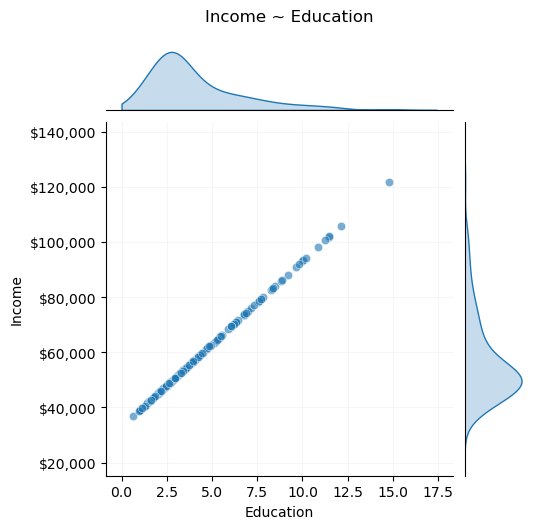

In [35]:
#| code-fold: true
#| warning: false

g = sns.JointGrid(data=df, x="Education", y="Income", marginal_ticks=False, height=5)
g.plot_joint(sns.scatterplot, alpha=0.6, marker="o")
g.plot_marginals(sns.kdeplot, fill=True, clip=(0, np.inf))
g.fig.suptitle(f"Income ~ Education", y=1.05)
g.ax_joint.grid(alpha=0.1)
# Formatting the sides
g.ax_joint.yaxis.set_major_formatter("${x:,.0f}")
g.ax_marg_x.tick_params(left=False, bottom=False)
g.ax_marg_y.tick_params(left=False, bottom=False)
g.ax_marg_y.set(xticklabels=[]);

Modeling this relationship is trivial. Given that it is a deterministic, linear function, we can use data to solve a linear system of equations and find the exact parameters of the relationship:

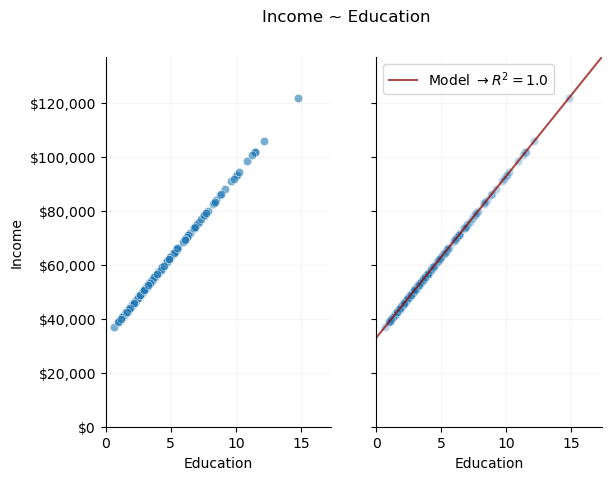

In [36]:
#| code-fold: true
fig, ax = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x="Education", y="Income", data=df, alpha=0.6, marker="o", ax=ax[0])
fig.suptitle("Income ~ Education")
ax[0].grid(alpha=0.1)
ax[0].yaxis.set_major_formatter("${x:,.0f}")
sns.despine(ax=ax[0])
ax[0].set(
    xlim=(0, df["Education"].max() + df["Education"].std()),
    ylim=(0, df["Income"].max() + df["Income"].std()),
)
ax[1].set(
    xlim=(0, df["Education"].max() + df["Education"].std()),
    ylim=(0, df["Income"].max() + df["Income"].std()),
)
X_test, y_pred, _, r2, _ = model_data_lm(1, df)
ax[1].grid(alpha=0.1)
sns.scatterplot(x="Education", y="Income", data=df, alpha=0.3, marker="o", ax=ax[1])
ax[1].plot(
    X_test,
    y_pred,
    color="darkred",
    alpha=0.7,
    label=r"Model $\rightarrow R^2=$" + str(round(r2, 2)),
)
ax[1].legend()
sns.despine(ax=ax[1]);

$R^2$ is the percentage of variance in the outcome, income, that our model can describe (in this case 100%, a perfect fit). We've created a perfect model of the DGP.

## Modeling a Non-Deterministic Process
In policy analysis settings, it's rare that we would encounter deterministic processes that we have any interest in modeling. Instead, we typically encounter processes with some stochastic element. For example, the following is a new DGP, where income is a linear function of years of education, but with an added random variable, representing noise.

In [37]:
noise_std = 9000
DGP = lambda x: 33000 + 6000 * x + np.random.normal(0, noise_std, size=len(x))

$$
income = 33000 + 6000 \times education + \mathcal{N}(0, 9000)
$$

In [38]:
df["Income"] = DGP(education)

c:\Users\peteramerkhanian\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\peteramerkhanian\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


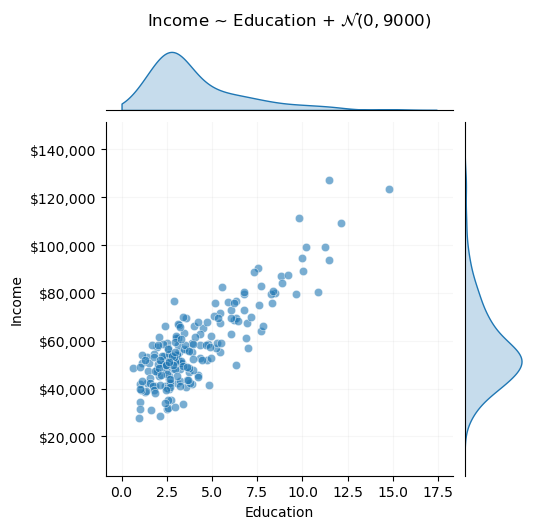

In [39]:
#| code-fold: true
#| warning: false

g = sns.JointGrid(data=df, x="Education", y="Income", marginal_ticks=False, height=5)
g.plot_joint(sns.scatterplot, alpha=0.6, marker="o")
g.plot_marginals(sns.kdeplot, fill=True, clip=(0, np.inf))
g.fig.suptitle(f"Income ~ Education + $\mathcal{{N}}(0, {noise_std})$", y=1.05)
g.ax_joint.grid(alpha=0.1)

# Formatting the sides
g.ax_joint.yaxis.set_major_formatter("${x:,.0f}")
g.ax_marg_x.tick_params(left=False, bottom=False)
g.ax_marg_y.tick_params(left=False, bottom=False)
g.ax_marg_y.set(xticklabels=[]);

Modeling this process is no longer trivial. Rather than solve a simple system of equations algebraically, we must use an estimation method to find a "best" model. Estimation involves choices, and finding the best model for this data is more complex than it may seem at first glance.

### Overfitting

We will model this DGP using a linear regression fit via the ordinary least squares algorithm. We face a number of choices in using linear regression -- for example, we can freely use polynomial transformations to make our model flexible to non-linear relationships. Here we'll examine the behavior of a polynomial regression by setting up an infinite series as follows:
$$
y_p=\sum_{p=0}^{\infty} \beta_p x^p
$$
As this series expands, it represents a polynomial regression of degree $p$. When we expand, we can examine how this model performs as the degree increases.

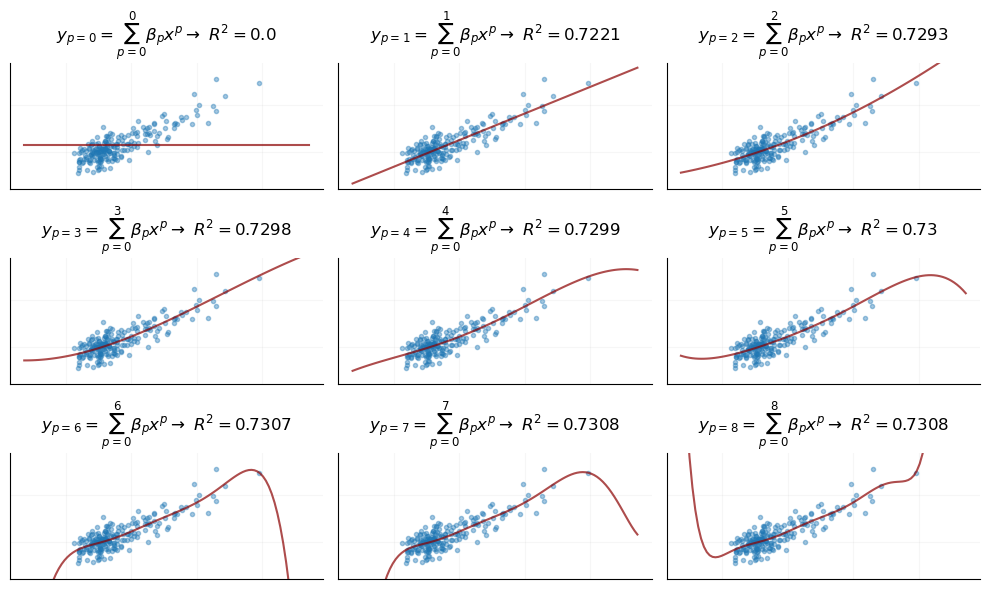

In [40]:
#| code-fold: true
y_max = 3
x_max = 3
fig, ax = plt.subplots(x_max, y_max, sharey=True, sharex=True, figsize=(10, 6))
degree = 0
for i in range(x_max):
    for j in range(y_max):
        X_test, y_pred, _, r2, _ = model_data_lm(degree, df)
        ax[i, j].set_ylim(
            df["Income"].min() - df["Income"].std(),
            df["Income"].max() + df["Income"].std(),
        )
        ax[i, j].grid(alpha=0.1)
        sns.despine(ax=ax[i, j])
        ax[i, j].plot(df["Education"], df["Income"], ".", alpha=0.4, color="tab:blue")
        ax[i, j].plot(X_test, y_pred, color="darkred", alpha=0.7)
        ax[i, j].set(yticklabels=[], xticklabels=[])
        ax[i, j].tick_params(left=False, bottom=False)
        ax[i, j].set_title(
            r"$y_{{p={}}}=\sum_{{p=0}}^{} \beta_p x^p \rightarrow$ ".format(
                degree, degree
            )
            + r"$R^2=$"
            + f"{round(r2, 4)}",
            size=12,
        )
        degree += 1

fig.tight_layout()

Regardless of what you think of the shape of these curves, it's clear that as the series expands and $p$ increases, we see improving model accuracy, $R^2$. We can expand this series until we find a seemingly "optimal" model.

#### An "Optimal" Model
We expand the series, or, in more typical language, we conduct a "grid-search," to find the optimal model as defined by the maximum $R^2$ score:

In [41]:
r2s = []
max_root = 25
roots = range(max_root)
for degree in roots:
    _, _, _, r2, _ = model_data_lm(degree, df)
    r2s.append(r2)
r2s = np.array(r2s)

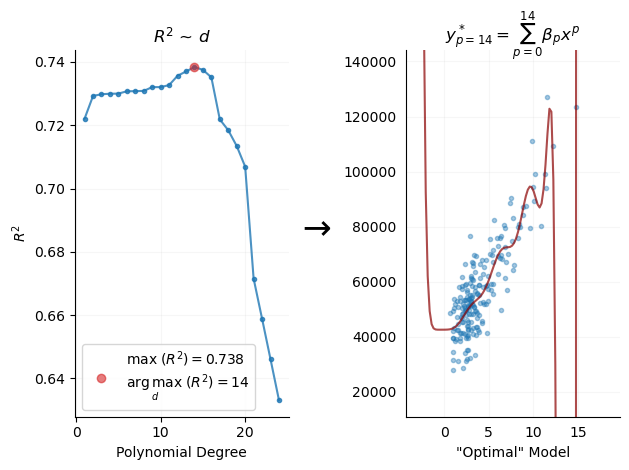

In [42]:
#| code-fold: true
fig, ax = plt.subplots(1, 2)
ax[0].plot(roots[1:], r2s[1:], ".-", alpha=0.8)
ax[0].set_title("$R^2$ ~ $d$")
ax[0].plot(
    np.argmax(r2s),
    np.max(r2s),
    "o",
    color="tab:red",
    alpha=0.6,
    label=f"$\max \; (R^2)=${round(np.max(r2s), 3)}\n"
    + r"$ \underset{d}{\arg\max} \; (R^2)=$"
    + f"{np.argmax(r2s)}",
)
ax[0].set(xlabel="Polynomial Degree", ylabel="$R^2$")
ax[0].legend()
ax[0].grid(alpha=0.1)
sns.despine(ax=ax[0])

degree = np.argmax(r2s)
X_test, y_pred, _, r2, optimal_model = model_data_lm(degree, df)
ax[1].set_ylabel(r"$\downarrow$", size=25)
ax[1].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax[1].grid(alpha=0.1)
sns.despine(ax=ax[1])
ax[1].plot(df["Education"], df["Income"], ".", alpha=0.4, color="tab:blue")
ax[1].plot(X_test, y_pred, color="darkred", alpha=0.7)
ax[1].set_xlabel('"Optimal" Model')
ax[1].tick_params(left=False, bottom=False)
ax[1].set_title(
    r"$y^*_{{p={}}}=\sum_{{p=0}}^{{{}}} \beta_p x^p$ ".format(degree, degree)
)
fig.tight_layout()

We see that the accuracy-maximizing model, $y^*$, is a very high degree polynomial. Our simple, empirical investigation leads us to conclude that this is the "best" model.

However, it's clear that the model is overly complex and likely problematic given these visuals, where there are extreme swings in predictions. It would greatly benefit us to have a clear quantity that represents why this model may be problematic.

### Out of sample performance, or, what happens when we collect new data?
One simple way to further evaluate this model is to collect new data (from outside of our original sample) and then evaluate whether the model can describe variation in that new data. Given that we are working with synthetic data, it's straightforward to simulate new observations from the underlying DGP, and thus "collect" new data. In the following plot, the right-hand pane is a fresh sample of individuals with observed education and income values:

In [43]:
education = education_dgp(1000)
correct_income = DGP(education)

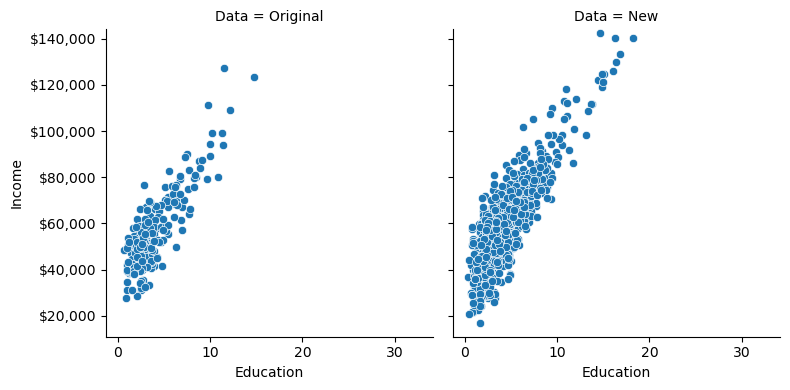

In [44]:
#| code-fold: true
om_residuals = np.abs(optimal_model.predict(education.reshape(-1, 1)) - correct_income)
new_data_df = pd.DataFrame()
new_data_df["Education"] = education
new_data_df["Residuals"] = om_residuals
new_data_df["Income"] = correct_income
new_data_df["Data"] = "New"
new_data_df = pd.concat(
    [
        df.assign(
            Residuals=np.abs(
                optimal_model.predict(df[["Education"]].values) - df["Income"]
            )
        ).assign(Data="Original"),
        new_data_df,
    ],
    axis=0,
)
ax = sns.relplot(
    height=4,
    data=new_data_df,
    x="Education",
    y="Income",
    col="Data",
    kind="scatter",
    legend=False,
)

ax.axes[0][0].yaxis.set_major_formatter("${x:,.0f}")
# ax.axes[0][0].plot(X_test, y_pred, color='darkred', alpha=.7)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.tight_layout();

Here we can see that, when exposed to a new sample from the same DGP, the model produces extreme error.

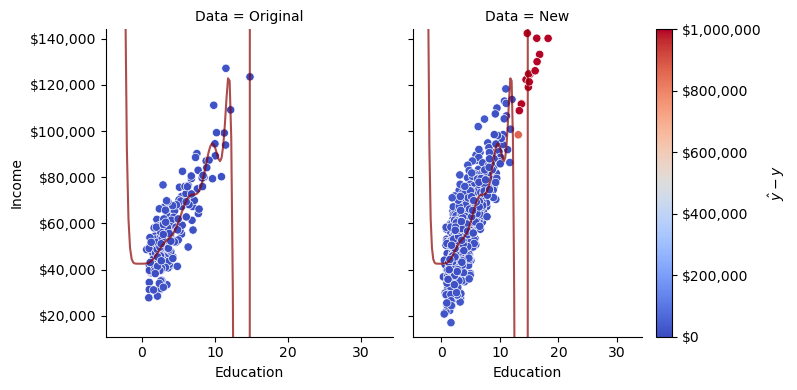

In [45]:
#| code-fold: true
norm = (0, 1000000)
norm = plt.Normalize(*norm)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.relplot(
    height=4,
    data=new_data_df,
    x="Education",
    y="Income",
    col="Data",
    hue="Residuals",
    kind="scatter",
    palette="coolwarm",
    hue_norm=norm,
    legend=False,
)
ax.axes[0][0].yaxis.set_major_formatter("${x:,.0f}")
ax.axes[0][1].figure.colorbar(sm, ax=ax.axes[0][1], format="${x:,.0f}").set_label(
    r"$\hat{y}-y$"
)
ax.axes[0][1].plot(X_test, y_pred, color="darkred", alpha=0.7)
ax.axes[0][0].plot(X_test, y_pred, color="darkred", alpha=0.7)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.tight_layout();

We quantify this error as follows:

In [46]:
#| code-fold: true
rmse = lambda y, y_hat: np.sqrt(np.mean((y_hat - y) ** 2))
output_1 = pd.DataFrame(
    {
        "r2": [
            r2_score(correct_income, optimal_model.predict(education.reshape(-1, 1)))
        ],
        "rmse": [rmse(optimal_model.predict(education.reshape(-1, 1)), correct_income)],
    },
    index=["p=14"],
)
round(output_1, 2)

,r2,rmse
p=14,-1975424250597210112.00,26686561853746.36


This is clearly a bad model. What's worrying is that it *seemed* like the best model when we simply examined model accuracy on one dataset. This raises the possibility that we might be duped into selecting models like this in practice.

Out of curiosity, let's see how an extremely simply model, a linear regression with $p=1$ compares on this new data.

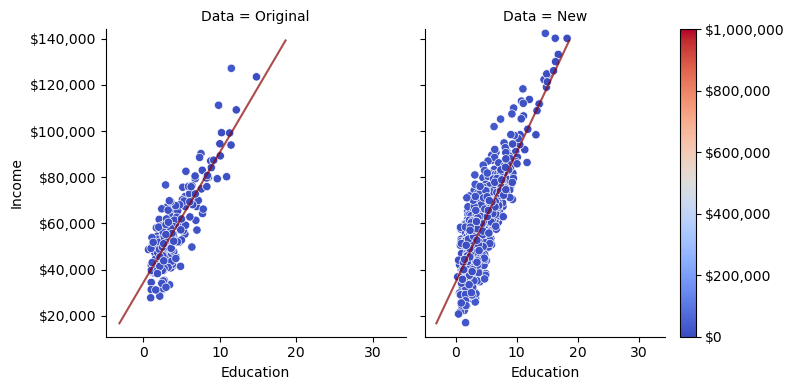

In [47]:
#| code-fold: true
X_test, y_pred, _, r2, sub_optimal_model = model_data_lm(1, df)
new_data_df.loc[new_data_df["Data"] == "New", "Degree 1 Residuals"] = np.abs(
    sub_optimal_model.predict(education.reshape(-1, 1)) - correct_income
)
new_data_df.loc[new_data_df["Data"] == "Original", "Degree 1 Residuals"] = np.abs(
    sub_optimal_model.predict(df[["Education"]].values) - df["Income"]
)

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
ax = sns.relplot(
    height=4,
    data=new_data_df,
    x="Education",
    y="Income",
    col="Data",
    hue="Degree 1 Residuals",
    kind="scatter",
    palette="coolwarm",
    hue_norm=norm,
    legend=False,
)

ax.axes[0][0].yaxis.set_major_formatter("${x:,.0f}")
ax.axes[0][1].figure.colorbar(sm, ax=ax.axes[0][1], format="${x:,.0f}")

ax.axes[0][1].plot(X_test, y_pred, color="darkred", alpha=0.7)
ax.axes[0][0].plot(X_test, y_pred, color="darkred", alpha=0.7)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.axes[0][0].set_ylim(
    df["Income"].min() - df["Income"].std(), df["Income"].max() + df["Income"].std()
)
ax.tight_layout();

This is a very good fit, even though our previous empirical fitting process told us that the high $p$ model was optimal.

In [48]:
#| code-fold: true
output_2 = pd.DataFrame(
    {
        "r2": [
            r2_score(
                correct_income, sub_optimal_model.predict(education.reshape(-1, 1))
            )
        ],
        "rmse": [
            rmse(sub_optimal_model.predict(education.reshape(-1, 1)), correct_income)
        ],
    },
    index=["p=1"],
)
round(output_2, 2)

,r2,rmse
p=1,0.77,9139.36


We have the benefit of already knowing that $p=1$ matches the functional form of the true DGP, but even if we didn't know that in advance, out-of-sample performance seems like a better way of evaluating whether or not our model gets at the underlying DGP of the observations.

# The Train-Test Split
The process we just went through is analogous to a resampling method called the train-test split.  

In the real world, we rarely can just collect more data. However, it is straightforward to simulate the data collection process using resampling methods. Specifically, we can split our original dataset into two parts -- a training dataset, wherein we will train and intially evaluate our model, and a "test" dataset, which we will use just as we used the newly collected data in the previous example, for more objective, empirical model evaluation.

In [49]:
np.random.seed(40)
train_stop = int(0.6 * n)
indices = df.sample(frac=1, replace=False).index
train_ind = indices[:train_stop]

Here we designate 60% of our data as training and 40% as test:

In [50]:
df.loc[:, "Sample"] = None
df.loc[train_ind, "Sample"] = "Train"
df.loc[df["Sample"] != "Train", "Sample"] = "Test"
df.head()

,Education,Income,Sample
0,4.72,51906.56,Train
1,6.95,67311.29,Test
2,5.44,71605.47,Train
3,2.06,61735.95,Train
4,4.25,45533.73,Train


Next, we hold the test data aside and only examine the training dataset.

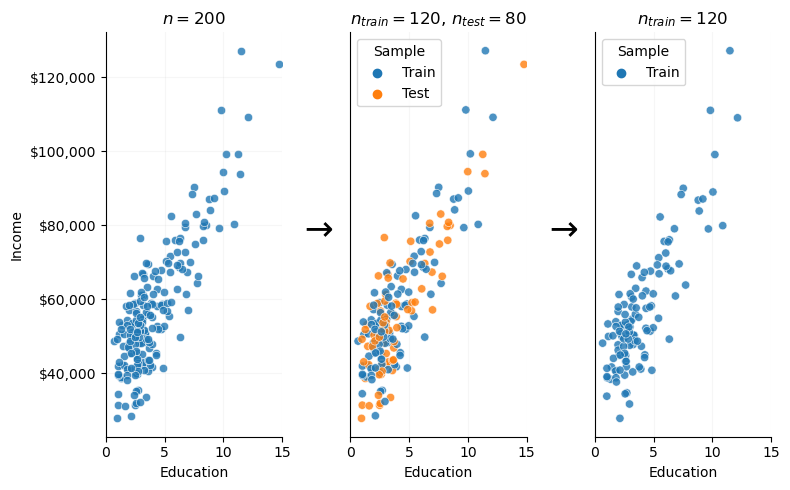

In [51]:
#| code-fold: true
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
sns.scatterplot(x="Education", y="Income", data=df, alpha=0.8, marker="o", ax=ax[0])
ax[0].set_title("$n=$" + str(n))
ax[0].grid(alpha=0.1)
ax[0].yaxis.set_major_formatter("${x:,.0f}")
ax[0].set_xlim(0, 15)
sns.despine(ax=ax[0])

sns.scatterplot(
    x="Education", y="Income", hue="Sample", data=df, alpha=0.8, marker="o", ax=ax[1]
)
ax[1].set_title(
    "$n_{train}=$" + str(train_stop) + ", $n_{test}=$" + str(n - train_stop)
)
ax[1].set_ylabel(r"$\downarrow$", size=25)
ax[1].set_yticks([])
ax[1].grid(alpha=0.1)
ax[1].set_xlim(0, 15)
sns.despine(ax=ax[1])

sns.scatterplot(
    x="Education",
    y="Income",
    hue="Sample",
    data=df.query("Sample == 'Train'"),
    alpha=0.8,
    marker="o",
    ax=ax[2],
    legend=True,
)
ax[2].set_title("$n_{train}=$" + str(train_stop))
ax[2].set_ylabel(r"$\downarrow$", size=25)
ax[2].set_yticks([])
ax[2].grid(alpha=0.1)
ax[2].set_xlim(0, 15)
sns.despine(ax=ax[2])
fig.tight_layout()

We proceed to train models on the training data, and evaluate each model on the test dataset. We do that process for each degree polynomial regression.

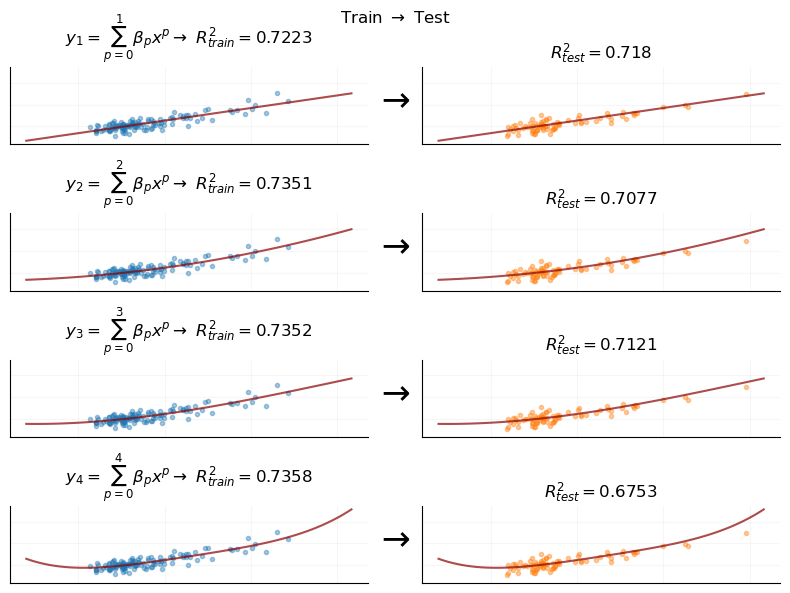

In [52]:
#| code-fold: true
x_max = 2
y_max = 4
fig, ax = plt.subplots(y_max, x_max, sharey=True, sharex=True, figsize=(8, 6))
degree = 1
sub_df = df.query("Sample == 'Train'")
test_df = df.query("Sample == 'Test'")

for j in range(y_max):
    X_test, y_pred, rmse, r2, model = model_data_lm(degree, sub_df)

    r2_test = r2_score(
        test_df["Income"].values, model.predict(test_df[["Education"]].values)
    )

    ax[j, 1].plot(
        test_df["Education"], test_df["Income"], ".", alpha=0.4, color="tab:orange"
    )
    ax[j, 0].plot(
        sub_df["Education"], sub_df["Income"], ".", alpha=0.4, color="tab:blue"
    )

    ax[j, 1].grid(alpha=0.1)
    ax[j, 0].grid(alpha=0.1)
    sns.despine(ax=ax[j, 1])
    sns.despine(ax=ax[j, 0])

    ax[j, 1].set_ylabel(r"$\downarrow$", size=25)

    ax[j, 0].plot(X_test, y_pred, color="darkred", alpha=0.7)
    ax[j, 1].plot(X_test, y_pred, color="darkred", alpha=0.7)
    ax[j, 0].set(yticklabels=[], xticklabels=[])
    ax[j, 0].tick_params(left=False, bottom=False)
    ax[j, 1].set(yticklabels=[], xticklabels=[])
    ax[j, 1].tick_params(left=False, bottom=False)
    ax[j, 0].set_title(
        r"$y_{}=\sum_{{p=0}}^{} \beta_p x^p \rightarrow$ ".format(degree, degree)
        + r"$R_{train}^2=$"
        + f"{round(r2, 4)}",
        size=12,
    )
    ax[j, 1].set_title(
        r"$R_{test}^2=$" + f"{round(r2_test, 4)}", size=12, color="black"
    )
    degree += 1
fig.tight_layout()
fig.suptitle(r"Train $\rightarrow$ Test");

When we examine the relationship between polynomial degree and $R^2$, we now seek the argument that maximizes $R^2_{test}$, rather than $R^2_{train}$.  

Here we'll also note that, typically, $R^2_{test} < R^2_{train}$.  

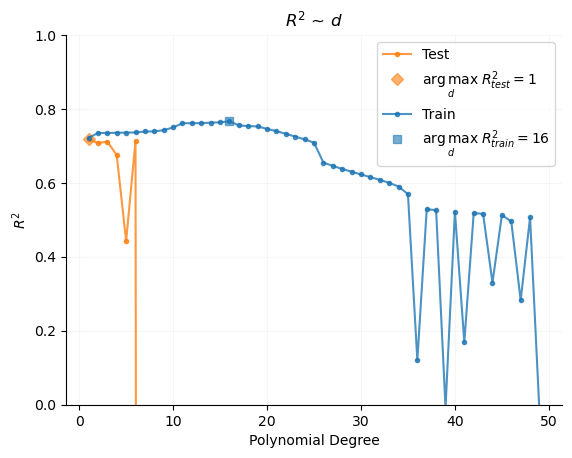

In [53]:
#| code-fold: true
r2s_test = []
r2s_train = []
max_root = 50
roots = range(max_root)
for degree in roots:
    X_test, y_pred, _, _, model = model_data_lm(degree, sub_df)

    r2_test = r2_score(
        test_df["Income"].values, model.predict(test_df[["Education"]].values)
    )
    r2_train = r2_score(
        sub_df["Income"].values, model.predict(sub_df[["Education"]].values)
    )
    r2s_test.append(r2_test)
    r2s_train.append(r2_train)
r2s_test = np.array(r2s_test)
r2s_train = np.array(r2s_train)

fig, ax = plt.subplots()
ax.plot(roots[1:], r2s_test[1:], ".-", alpha=0.8, label="Test", c="tab:orange")
ax.set_title("$R^2_{test}$ ~ $p$")
ax.plot(
    np.argmax(r2s_test),
    np.max(r2s_test),
    "D",
    color="tab:orange",
    alpha=0.6,
    label=r"$ \underset{d}{\arg\max} \; R^2_{test}=$" + f"{np.argmax(r2s_test)}",
)
ax.legend()
ax.grid(alpha=0.1)
sns.despine(ax=ax)
ax.set_ylim(0, 1)

ax.plot(roots[1:], r2s_train[1:], ".-", alpha=0.8, label="Train", c="tab:blue")
ax.set_title("$R^2$ ~ $d$")
ax.plot(
    np.argmax(r2s_train),
    np.max(r2s_train),
    "s",
    color="tab:blue",
    alpha=0.6,
    label=r"$ \underset{d}{\arg\max} \; R^2_{train}=$" + f"{np.argmax(r2s_train)}",
)
ax.set(xlabel="Polynomial Degree", ylabel="$R^2$")
ax.legend()
ax.grid(alpha=0.1)
sns.despine(ax=ax)

Here we see the benefit of the train-test split. Were we using only a training dataset, we may naively optimize our model at $p=16$. However, by using a test dataset for model evaluation, our empirically optimized model is at $p=1$, thus matching the true functional form of the underlying data generating process, a linear function of the form:

$$
income = 33000 + 6000 \times education + \mathcal{N}(0, 9000)
$$
Indeed, we can see the exact functional form that our optimal model takes:

In [54]:
resid = correct_income - sub_optimal_model.predict(education.reshape(-1, 1))
print(
    f"income = {round(sub_optimal_model[1].intercept_, 2)}"
    + f" + {round(sub_optimal_model[1].coef_[-1], 2)}*education"
    + f" + N({round(resid.mean(), 2)}, {round(resid.std(), 2)})"
)

income = 34467.82 + 5635.04*education + N(-90.57, 9138.91)


This is very close to the data generating process!

### An Aside about Nonparametric models
The issues we just discussed in the context of polynomial regression only compound as we exit the realm of linear regression and consider nonparametric models like decision trees. For example, when we examine a decision tree model and vary $M$, the number of partitions of the feature space that the model uses (a measure of complexity), we see extreme divergence between training the testing performance.

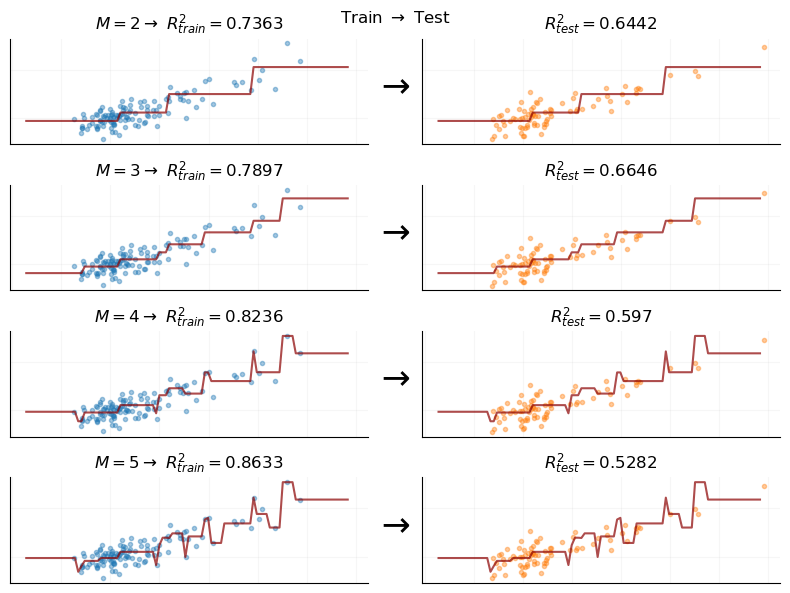

In [55]:
#| code-fold: true
def model_data_cart(degree, df):
    X = df[["Education"]].values
    y = df["Income"].values

    model = DecisionTreeRegressor(random_state=1, max_depth=degree)
    model.fit(X, y)

    rmse = mean_squared_error(y, model.predict(X)) ** 0.5
    r2 = r2_score(y, model.predict(X))

    X_test = np.linspace(X.min() - X.std(), X.max() + X.std(), 100).reshape(-1, 1)
    y_pred = model.predict(X_test)

    return X_test, y_pred, rmse, r2, model


x_max = 2
y_max = 4
fig, ax = plt.subplots(y_max, x_max, sharey=True, sharex=True, figsize=(8, 6))
degree = 2
sub_df = df.query("Sample == 'Train'")
test_df = df.query("Sample == 'Test'")

for j in range(y_max):
    X_test, y_pred, rmse, r2, model = model_data_cart(degree, sub_df)

    r2_test = r2_score(
        test_df["Income"].values, model.predict(test_df[["Education"]].values)
    )

    ax[j, 1].plot(
        test_df["Education"], test_df["Income"], ".", alpha=0.4, color="tab:orange"
    )
    ax[j, 0].plot(
        sub_df["Education"], sub_df["Income"], ".", alpha=0.4, color="tab:blue"
    )

    ax[j, 1].grid(alpha=0.1)
    ax[j, 0].grid(alpha=0.1)
    sns.despine(ax=ax[j, 1])
    sns.despine(ax=ax[j, 0])

    ax[j, 1].set_ylabel(r"$\downarrow$", size=25)

    ax[j, 0].plot(X_test, y_pred, color="darkred", alpha=0.7)
    ax[j, 1].plot(X_test, y_pred, color="darkred", alpha=0.7)
    ax[j, 0].set(yticklabels=[], xticklabels=[])
    ax[j, 0].tick_params(left=False, bottom=False)
    ax[j, 1].set(yticklabels=[], xticklabels=[])
    ax[j, 1].tick_params(left=False, bottom=False)
    ax[j, 0].set_title(
        r"$M={} \rightarrow$ ".format(degree) + r"$R^2_{train}=$" + f"{round(r2, 4)}",
        size=12,
    )
    ax[j, 1].set_title(
        r"$R_{test}^2=$" + f"{round(r2_test, 4)}", size=12, color="black"
    )
    degree += 1
fig.tight_layout()
fig.suptitle(r"Train $\rightarrow$ Test");

Indeed, it even seems visually that, at some level,  
$$
\lim_{M \rightarrow \infty} R_{train}^2 \approx 1.0
$$
Being able to perfectly model a DGP that is in itself random is a worrying sign, and this condition creates especial danger of over-fitting and creating overly-confident models when using decision trees.

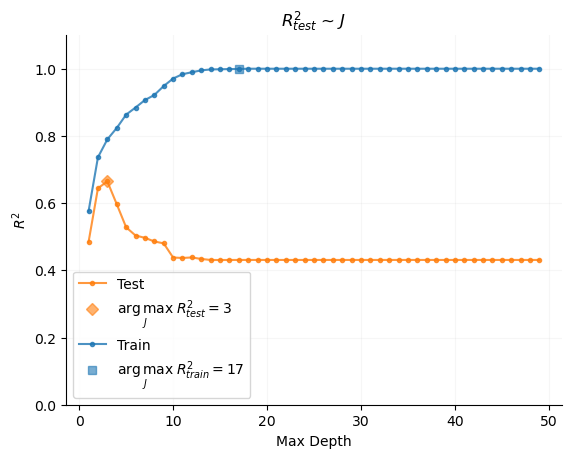

In [56]:
#| code-fold: true
r2s_test_cart = []
r2s_cart = []
max_root = 50
roots = range(1, max_root)
for degree in roots:
    X_test, y_pred, rmse, r2, model = model_data_cart(degree, sub_df)
    r2_test = r2_score(
        test_df["Income"].values, model.predict(test_df[["Education"]].values)
    )
    r2s_test_cart.append(r2_test)
    r2 = r2_score(sub_df["Income"].values, model.predict(sub_df[["Education"]].values))
    r2s_cart.append(r2)

r2s_test_cart = np.array(r2s_test_cart)
r2s_cart = np.array(r2s_cart)

fig, ax = plt.subplots()
ax.plot(roots, r2s_test_cart, ".-", alpha=0.8, label="Test", c="tab:orange")
ax.set_title("$R^2_{test}$ ~ $J$")
ax.plot(
    np.argmax(r2s_test_cart) + 1,
    np.max(r2s_test_cart),
    "D",
    color="tab:orange",
    alpha=0.6,
    label=r"$ \underset{J}{\arg\max} \; R^2_{test}=$" + f"{np.argmax(r2s_test_cart)+1}",
)
ax.legend()
ax.grid(alpha=0.1)
sns.despine(ax=ax)
ax.set_ylim(0, 1.1)

ax.plot(roots, r2s_cart, ".-", alpha=0.8, label="Train", c="tab:blue")
ax.plot(
    np.argmax(r2s_cart),
    np.max(r2s_cart),
    "s",
    color="tab:blue",
    alpha=0.6,
    label=r"$ \underset{J}{\arg\max} \; R^2_{train}=$" + f"{np.argmax(r2s_cart)}",
)
ax.set(xlabel="Max Depth", ylabel="$R^2$")
ax.legend()
ax.grid(alpha=0.1)
sns.despine(ax=ax)